## 🚀 Day 6/15 — Fine-Tuning with Unsloth AI

# Gemma 3n for Medical Vision Q&A with Unsloth AI

## Project Goal

The primary objective of this project is to develop a specialized, multimodal AI assistant capable of analyzing medical images and engaging in multi-turn, context-aware conversations about them.


---
### 👋🏻 About Me

Hi, I'm **Aasher Kamal** — a Generative & Agentic AI developer passionate about building intelligent systems with LLMs.

I have started a **15-day challenge** to master fine-tuning using the open-source **Unsloth AI** framework. This journey will cover everything from LoRA and QLoRA to reinforcement learning, vision, and TTS fine-tuning — all hands-on, all open-source.

I'll be documenting my learnings, experiments, and challenges daily.

---

### 🌐 Connect with Me

- [LinkedIn](https://www.linkedin.com/in/aasher-kamal/)
- [GitHub](https://github.com/aasherkamal216)
- [X (Twitter)](https://x.com/Aasher_Kamal)
- [Facebook](https://www.facebook.com/aasher.kamal)
- [Website](https://aasherkamal.framer.website/)

Let’s build and learn together! 💡

### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastVisionModel
import torch

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
    load_in_4bit = True,
    max_seq_length = 2048,
    use_gradient_checkpointing = "unsloth",
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,                           # The larger, the higher the accuracy
    lora_alpha = 32,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
    target_modules = "all-linear",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
### Dataset
We'll use `MedificsDataset` for this project, which is a dataset of conversations on radiology and skin cancer images.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("WinterSchool/MedificsDataset", split = "train")

In [5]:
dataset

Dataset({
    features: ['id', 'image', 'conversation'],
    num_rows: 3800
})

In [13]:
dataset[15]["conversation"]

{'data': [{'answer': 'The anterior segment optical coherence tomography shows abnormal apposition at the graft-host junction in a case of operated penetrating keratoplasty.',
   'question': 'What does the anterior segment optical coherence tomography show in this case?'},
  {'answer': 'Penetrating keratoplasty is a surgical procedure in which a damaged or diseased cornea is replaced with a healthy donor cornea.',
   'question': 'What is penetrating keratoplasty?'},
  {'answer': 'Abnormal apposition at the graft-host junction may indicate issues with the healing process or complications from the surgery in the specific area where the graft meets the host tissue.',
   'question': 'What does abnormal apposition at the graft-host junction indicate?'},
  {'answer': 'Possible causes of abnormal apposition at the graft-host junction include inflammation, infection, rejection of the donor tissue, or issues with the sutures holding the graft in place.',
   'question': 'What are some possible ca

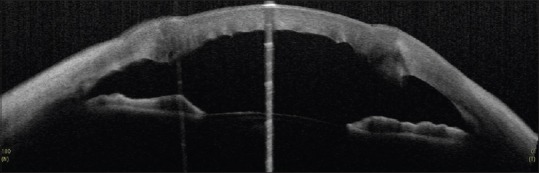

In [14]:
dataset[15]["image"]

In [ ]:
from datasets import Dataset, Image
from PIL import Image as PILImage
import numpy as np

def format_medical_vision_data(sample):
    """
    Transforms a single sample from your custom dataset format to the
    Unsloth/Hugging Face standard for multimodal conversation.
    """
    image = sample["image"][0]
    conversation_data = sample["conversation"][0]["data"]

    formatted_conversation = []
    for i, qa_pair in enumerate(conversation_data):
        question = qa_pair["question"]
        answer = qa_pair["answer"]

        if i == 0:
            user_content = [
                {"type": "text", "text": question},
                {"type": "image", "image": image}
            ]
        else:
            user_content = [{"type": "text", "text": question}]

        formatted_conversation.append({"role": "user", "content": user_content})
        formatted_conversation.append({"role": "assistant", "content": [{"type": "text", "text": answer}]})


    return {"messages": [formatted_conversation]}

dataset.set_transform(format_medical_vision_data)

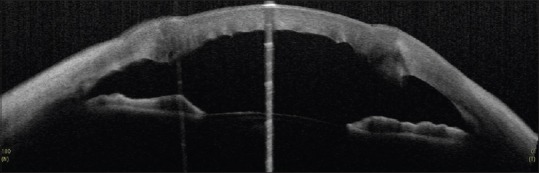

In [16]:
dataset[15]['messages'][0]['content'][1]['image']

In [30]:
dataset[15]['messages']

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'What does the anterior segment optical coherence tomography show in this case?'},
   {'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=539x173>}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The anterior segment optical coherence tomography shows abnormal apposition at the graft-host junction in a case of operated penetrating keratoplasty.'}]},
 {'role': 'user',
  'content': [{'type': 'text', 'text': 'What is penetrating keratoplasty?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Penetrating keratoplasty is a surgical procedure in which a damaged or diseased cornea is replaced with a healthy donor cornea.'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'What does abnormal apposition at the graft-host junction indicate?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Abnormal apposition at the graft-ho

Lets take the Gemma 3n instruction chat template and use it in our base model

In [24]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3n"
)

<a name="Train"></a>
### Train the model


In [38]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.1,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        save_steps = 100,
        save_total_limit = 3,
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
trainer_stats = trainer.train(resume_from_checkpoint = True)

<a name="Inference"></a>
### Inference
Let's run the model and test on test dataset

In [72]:
from datasets import load_dataset
test_dataset = load_dataset("WinterSchool/MedificsDataset", split = "test")
test_dataset.set_transform(format_medical_vision_data)

In [91]:
test_dataset[0]['messages']

[{'role': 'user',
  'content': [{'type': 'text', 'text': 'What can be seen in this CT scan?'},
   {'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=747x622>}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'In this CT scan, we can see cervical lymphadenopathy, the internal jugular vein, and an ectatic common carotid artery.'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'What does the yellow arrow indicate in the CT scan?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The yellow arrow indicates cervical lymphadenopathy.'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'What is the significance of the ectatic common carotid artery shown in the scan?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'An ectatic common carotid artery refers to an abnormal dilation of the artery, which can sometimes indicate underlying cardiovascular issues.'}]},
 {'role'

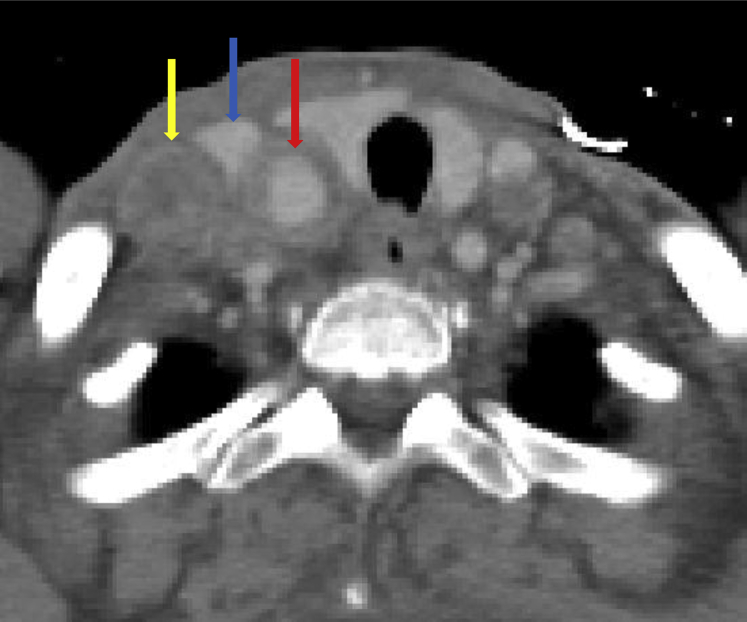

In [92]:
test_dataset[0]['messages'][0]['content'][1]['image']

In [93]:
from transformers import TextStreamer

FastVisionModel.for_inference(model)

image = test_dataset[0]['messages'][0]['content'][1]['image']
instruction = test_dataset[0]['messages'][0]['content'][0]['text']

messages = [
    {
        "role": "user",
        "content": [{"type": "image", "image": image}, {"type": "text", "text": instruction}],
    }
]

In [55]:
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

text_streamer = TextStreamer(processor, skip_prompt=True)

result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=256,
    temperature=0.9,
    top_p=0.95,
    )

This CT scan shows a thyroid nodule with surrounding lymphadenopathy.<end_of_turn>


### Gradio Web App
We will use Gradio to create a web app for our model, allowing users to interact with it.

In [ ]:
import gradio as gr
import random
import torch
from transformers import TextStreamer


def refresh_sample(dataset):
    """
    Selects a new random sample from the dataset and resets the UI and state.
    """
    # 1. Pick a new random index
    new_index = random.randint(0, len(dataset) - 1)

    # 2. Get the sample
    sample = dataset[new_index]['messages']

    # 3. Extract the image
    image = sample[0]['content'][1]['image']

    # 4. Extract all user questions from the conversation
    user_questions = [turn['content'][0]['text'] for turn in sample if turn['role'] == 'user']

    # 5. Reset everything
    messages_state = [] # Clear conversation history

    return (
        new_index,
        messages_state,
        image,
        gr.Radio(choices=user_questions, value=user_questions[0], label="Sample Questions", interactive=True),
        gr.Button(interactive=True),
        "", # Clear model response
        ""  # Clear actual response
    )


def generate_answer(selected_question, sample_index, messages_history, dataset):
    """
    Generates a model response for the selected question and updates the conversation history.
    """
    # 1. Get the full sample data using the index
    sample = dataset[sample_index]['messages']

    # 2. Find the ground truth answer for the selected question
    ground_truth_answer = ""
    for i, turn in enumerate(sample):
        if turn['role'] == 'user' and turn['content'][0]['text'] == selected_question:
            # The next turn is the assistant's answer
            if i + 1 < len(sample) and sample[i+1]['role'] == 'assistant':
                ground_truth_answer = sample[i+1]['content'][0]['text']
                break

    # 3. Prepare the model input
    # Check if this is the first turn for this image. If so, include the image.
    if not messages_history:
        image = sample[0]['content'][1]['image']
        user_content = [{"type": "image", "image": image}, {"type": "text", "text": selected_question}]
    else:
        # For subsequent turns, only text is needed
        user_content = [{"type": "text", "text": selected_question}]

    # Append the new user message to the history
    messages_history.append({"role": "user", "content": user_content})

    # Apply chat template
    input_text = processor.apply_chat_template(messages_history, add_generation_prompt=True)

    # Tokenize inputs
    inputs = processor(
        # The processor can handle the image being None if it's not the first turn
        images=sample[0]['content'][1]['image'] if not messages_history else None,
        text=input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # 4. Generate the response
    result = model.generate(
        **inputs,
        max_new_tokens=128,
        temperature=0.8,
        top_p=0.95,
        use_cache=True,
    )

    # Decode the generated part of the output
    decoded_output = processor.batch_decode(result[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0].strip()

    # 5. Update the conversation history with the model's response
    messages_history.append({"role": "assistant", "content": [{"type": "text", "text": decoded_output}]})

    return decoded_output, ground_truth_answer, messages_history


# --- Build the Gradio App ---
with gr.Blocks(theme=gr.themes.Soft(), css="footer {display: none !important}") as app:
    gr.Markdown("# 🩺 Unsloth Gemma 3 Vision Inspector")
    gr.Markdown("Interact with your fine-tuned model. A new image and its questions are loaded randomly. Select a question to see the model's response and the ground truth.")

    # Hidden state components to store session data
    sample_index_state = gr.State(value=0)
    messages_state = gr.State(value=[])

    with gr.Row():
        with gr.Column(scale=1):
            image_display = gr.Image(label="Medical Image", type="pil")
            refresh_btn = gr.Button("🔄 Refresh Image", variant="primary")
            sample_questions_radio = gr.Radio(
                [],
                label="Sample Questions",
                info="Select a question to ask the model."
            )
            ask_btn = gr.Button("Send Message", variant="primary")
        with gr.Column(scale=2):
            model_response_md = gr.Markdown(value="🤖 Model Response")
            actual_response_md = gr.Markdown(value="✅ Actual Response (from Dataset)")

    # --- Wire up the component events to the functions ---

    # When the "Ask Question" button is clicked
    ask_btn.click(
        fn=generate_answer,
        inputs=[
            sample_questions_radio,
            sample_index_state,
            messages_state,
            gr.State(test_dataset)
        ],
        outputs=[
            model_response_md,
            actual_response_md,
            messages_state
        ],
        show_progress="full"  # THIS IS THE KEY for the loading indicator!
    )

    # When the app first loads or when the "Refresh" button is clicked
    # We use a list to trigger multiple events from one source
    load_event = [app.load, refresh_btn.click]
    for event in load_event:
        event(
            fn=refresh_sample,
            inputs=[gr.State(test_dataset)],
            outputs=[
                sample_index_state,
                messages_state,
                image_display,
                sample_questions_radio,
                ask_btn,
                model_response_md,
                actual_response_md,
            ]
        )

# Launch the app!
app.launch(debug=True, share=True)

In [ ]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

model.push_to_hub_merged("Aasher/Gemma-3n-4b-Vision-Finetuned", processor, token=hf_token)